## Preliminaries

In [53]:
import numpy as np
import pandas as pd

df = pd.read_csv("websitedata.csv.csv")
df.head()

# Data Description

# RecordID: identifier of the row of data
# IP Address: address of the user, who is visiting website
# LoggedInFlag: when user has an account and logged in
# ServerID: one of the servers user was routed through
# VisitPageFlag: when user clicked on the loyalty program page

FileNotFoundError: [Errno 2] No such file or directory: 'websitedata.csv.csv'

In [ ]:
df.shape # 184588 datapoints with 4 features(+1 for index)

(184588, 5)

## Let's check their distribution

<Axes: >

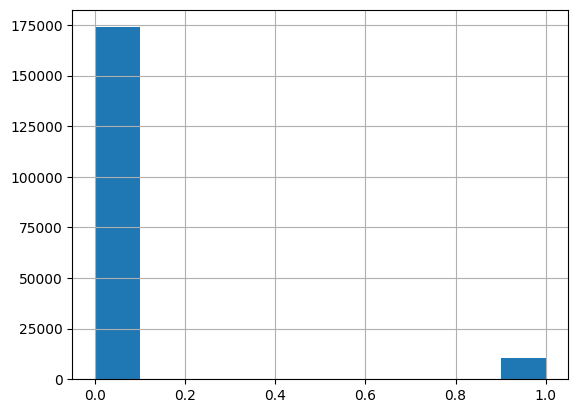

In [ ]:
df.VisitPageFlag.hist()

<Axes: >

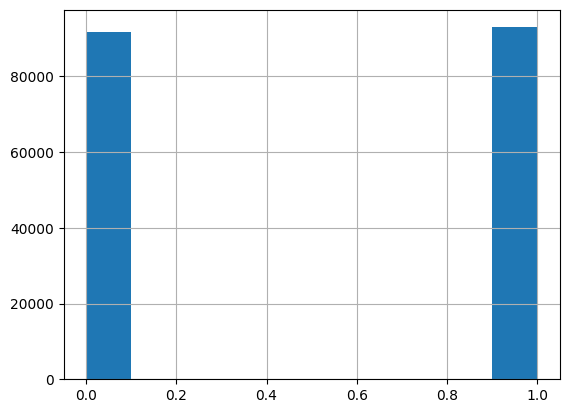

In [ ]:
df.LoggedInFlag.hist()

<Axes: >

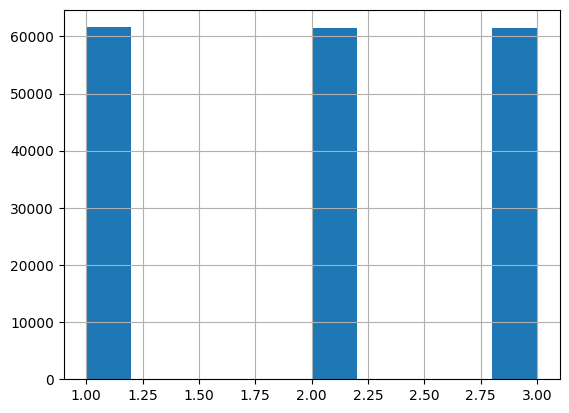

In [ ]:
df.ServerID.hist()

In [ ]:
#df2 = df.groupby("IP Address").agg({"VisitPageFlag":"sum"}).sort_values(by="VisitPageFlag", ascending=False)
#df2

,VisitPageFlag
IP Address,
89.13.192.2,4
178.14.224.9,3
194.2.158.8,3
78.8.166.9,3
78.6.64.3,3
...,...
179.5.55.6,0
179.5.46.7,0
179.5.35.5,0


In [ ]:
df = df.groupby(["IP Address", "LoggedInFlag", "ServerID"])["VisitPageFlag"].sum()
df = df.reset_index(name="VisitPageFlagSum")
df.head()

,IP Address,LoggedInFlag,ServerID,VisitPageFlagSum
0,0.0.108.2,0,1,0
1,0.0.109.6,1,1,0
2,0.0.111.8,0,3,0
3,0.0.160.9,1,2,0
4,0.0.163.1,0,2,0


<Axes: >

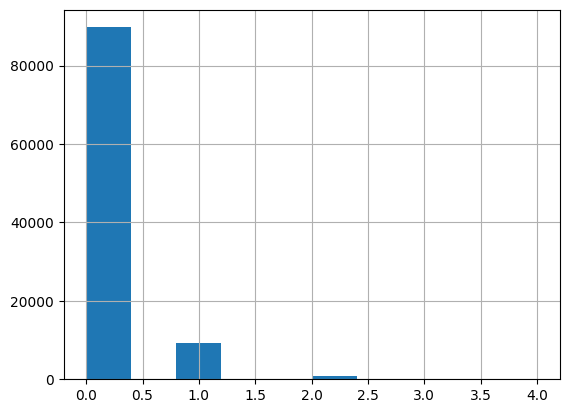

In [ ]:
df.VisitPageFlagSum.hist()

In [ ]:
df["VisitPageFlag"] = df["VisitPageFlagSum"].apply(lambda x: 1 if x != 0 else 0)
df.head()

,IP Address,LoggedInFlag,ServerID,VisitPageFlagSum,VisitPageFlag
0,0.0.108.2,0,1,0,0
1,0.0.109.6,1,1,0,0
2,0.0.111.8,0,3,0,0
3,0.0.160.9,1,2,0,0
4,0.0.163.1,0,2,0,0


### Splitting the Data into TEST and CONTROL groups. 
* ServerID 1 -> Test
* ServerID 2,3 -> Control

In [ ]:
df['Group'] = df['ServerID'].map({1:'Test', 2:'Control', 3:'Control'})
df.drop(['ServerID','VisitPageFlagSum'],axis=1, inplace=True)

In [ ]:
df.head()

,IP Address,LoggedInFlag,VisitPageFlag,group
0,0.0.108.2,0,0,Test
1,0.0.109.6,1,0,Test
2,0.0.111.8,0,0,Control
3,0.0.160.9,1,0,Control
4,0.0.163.1,0,0,Control


In [ ]:
df_control = df[df['group'] == 'Control'].copy()
df_control.reset_index(inplace=True, drop = True)

In [ ]:
df_test = df[df['group'] == 'Test'].copy()
df_test.reset_index(inplace=True, drop = True)

In [ ]:
df_control.head()

,IP Address,LoggedInFlag,VisitPageFlag,group
0,0.0.111.8,0,0,Control
1,0.0.160.9,1,0,Control
2,0.0.163.1,0,0,Control
3,0.0.178.9,1,0,Control
4,0.0.185.4,1,0,Control


## Distribution of data in each group

In [ ]:
df_control.describe().T

,count,mean,std,min,25%,50%,75%,max
LoggedInFlag,66460.0,0.503912,0.499988,0.0,0.0,1.0,1.0,1.0
VisitPageFlag,66460.0,0.092251,0.289382,0.0,0.0,0.0,0.0,1.0


In [ ]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
LoggedInFlag,33303.0,0.503258,0.499997,0.0,0.0,1.0,1.0,1.0
VisitPageFlag,33303.0,0.115515,0.319647,0.0,0.0,0.0,0.0,1.0


## Ratios

### Control Group

In [ ]:
control_sum_visit = df_control['VisitPageFlag'].count()
print("Sum visit for control group: ", control_sum_visit)
control_visit_1 = df_control[df_control['VisitPageFlag'] ==1]['VisitPageFlag'].count() # code counts the number of rows in df_control where the "VisitPageFlag" column is equal to 1.
print("Visit Page target = 1 : ", control_visit_1)

Sum visit for control group:  66460
Visit Page target = 1 :  6131


In [ ]:
control_ratio_visit = control_visit_1/control_sum_visit
control_ratio_visit

0.09225097803189888

### Test Group

In [ ]:
test_sum_visit = df_test['VisitPageFlag'].count()
print("Sum visit for test group: ", test_sum_visit)
test_visit_1 = df_test[df_test['VisitPageFlag'] ==1]['VisitPageFlag'].count()
print("Visit Page target = 1 : ", test_visit_1)

Sum visit for test group:  33303
Visit Page target = 1 :  3847


In [ ]:
test_ratio_visit = test_visit_1/test_sum_visit
test_ratio_visit

0.11551511875806984

When we look directly at the click rates, we see that there is a difference between the two groups. It seems that the new feature applied to the test group is getting more clicks. But this result can be misleading. Therefore, we should seek an answer to the question of whether there is a statistically significant difference. Now we will run A/B testing.

For A/B testing to be applied, the data set must satisfy the Normality and Variance homogeneity assumptions. Then, it can be passed to the implementation of the hypothesis tests.
   1. If normality and variance homogeneity is provided, an independent two-sample t-test (parametric test) is applied.
   2. If normality and homogeneity of variance are not provided, the Mann-Whitney U test (non-parametric test) is performed.
How to check the assumption of normality?
In this, we will first determine the H0 and H1 hypotheses.

- H0 : The assumption of normality is provided.
- H1 : The assumption of normality is not provided.

Now let's check the assumption of normality.

## Normality Assumption

In [ ]:
from scipy.stats import shapiro, levene, mannwhitneyu
    
test_stat, pvalue = shapiro(df_control["VisitPageFlag"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 0.3266, p-value = 0.0000


/home/rohan/miniconda3/envs/ner/lib/python3.9/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


H0 is rejected because the p-value is <0.05. The assumption of normality was not provided.

Therefore, we will use the Mann-Whitney U test.

H0 : There is no significant difference between the two groups in terms of click rate to the desired page.
H1 : There is a difference.

## Variance Homogeneity

### Levene

In [ ]:
test_stat, pvalue = levene(df_control["VisitPageFlag"],
                           df_test["VisitPageFlag"])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 133.5710, p-value = 0.0000


## Mann-Whitney U Test

In [ ]:
test_stat, pvalue = mannwhitneyu(df_control["VisitPageFlag"],
                                 df_test["VisitPageFlag"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 1080913226.5000, p-value = 0.0000


H0 is rejected because p-value<0.05. In other words, we can say statistically that there is a difference between the two groups.

In [ ]:
group_count = df.groupby(['group', 'VisitPageFlag'])['group'].count().reset_index(name='Count')
groupped = pd.crosstab(group_count['group'], group_count['VisitPageFlag'], values=group_count['Count'], aggfunc=np.sum, margins=True)

In [ ]:
100*groupped.div(groupped['All'], axis=0)

VisitPageFlag,0,1,All
group,,,
Control,90.774902,9.225098,100.0
Test,88.448488,11.551512,100.0
All,89.998296,10.001704,100.0


# Conclusion
While the rate of clicking on the link was 9.22% in the Control group, this rate increased to 11.55% in the Test group.
As a result of our tests, we can say that this rate increase is not accidental, but has been proven statistically.